In [1]:
import numpy             as np
import math
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import glob
import h5py as h
import random
import statistics as st
%matplotlib inline

In [2]:
def getParticles(file,EventLimit=0,particle=b'opticalphoton'):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(EventLimit>0):
        TotalEvents=EventLimit
    
    theEvents={}
    
    FudicalCount=0
    ElectronHits={}
    
    
    for Current_Event in range(0,TotalEvents):
        
        Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
        Current_Particles=data['MC']['particles'][Current_Particle_Mask]
        
        Photon_Mask = Current_Particles['particle_name'] == b'opticalphoton'
        
        print(data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_x"])
        X=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_x"]
        Y=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_y"]
        Z=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_z"]
        Volume=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_volume"]
        E=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["kin_energy"]


        Pos=np.array([X,Y,Z])
        theEvents[Current_Event]=[Pos,Volume,E]
    return theEvents

In [3]:
Data=getParticles("/media/ilker/Ilker/CRAB/Simulation/For_Nick/WithNicksYield.h5")

[-24.25742  -13.866631  39.507385 ...  72.217     69.47924  -74.69795 ]


0.3546511627906977
0.33643699565487273


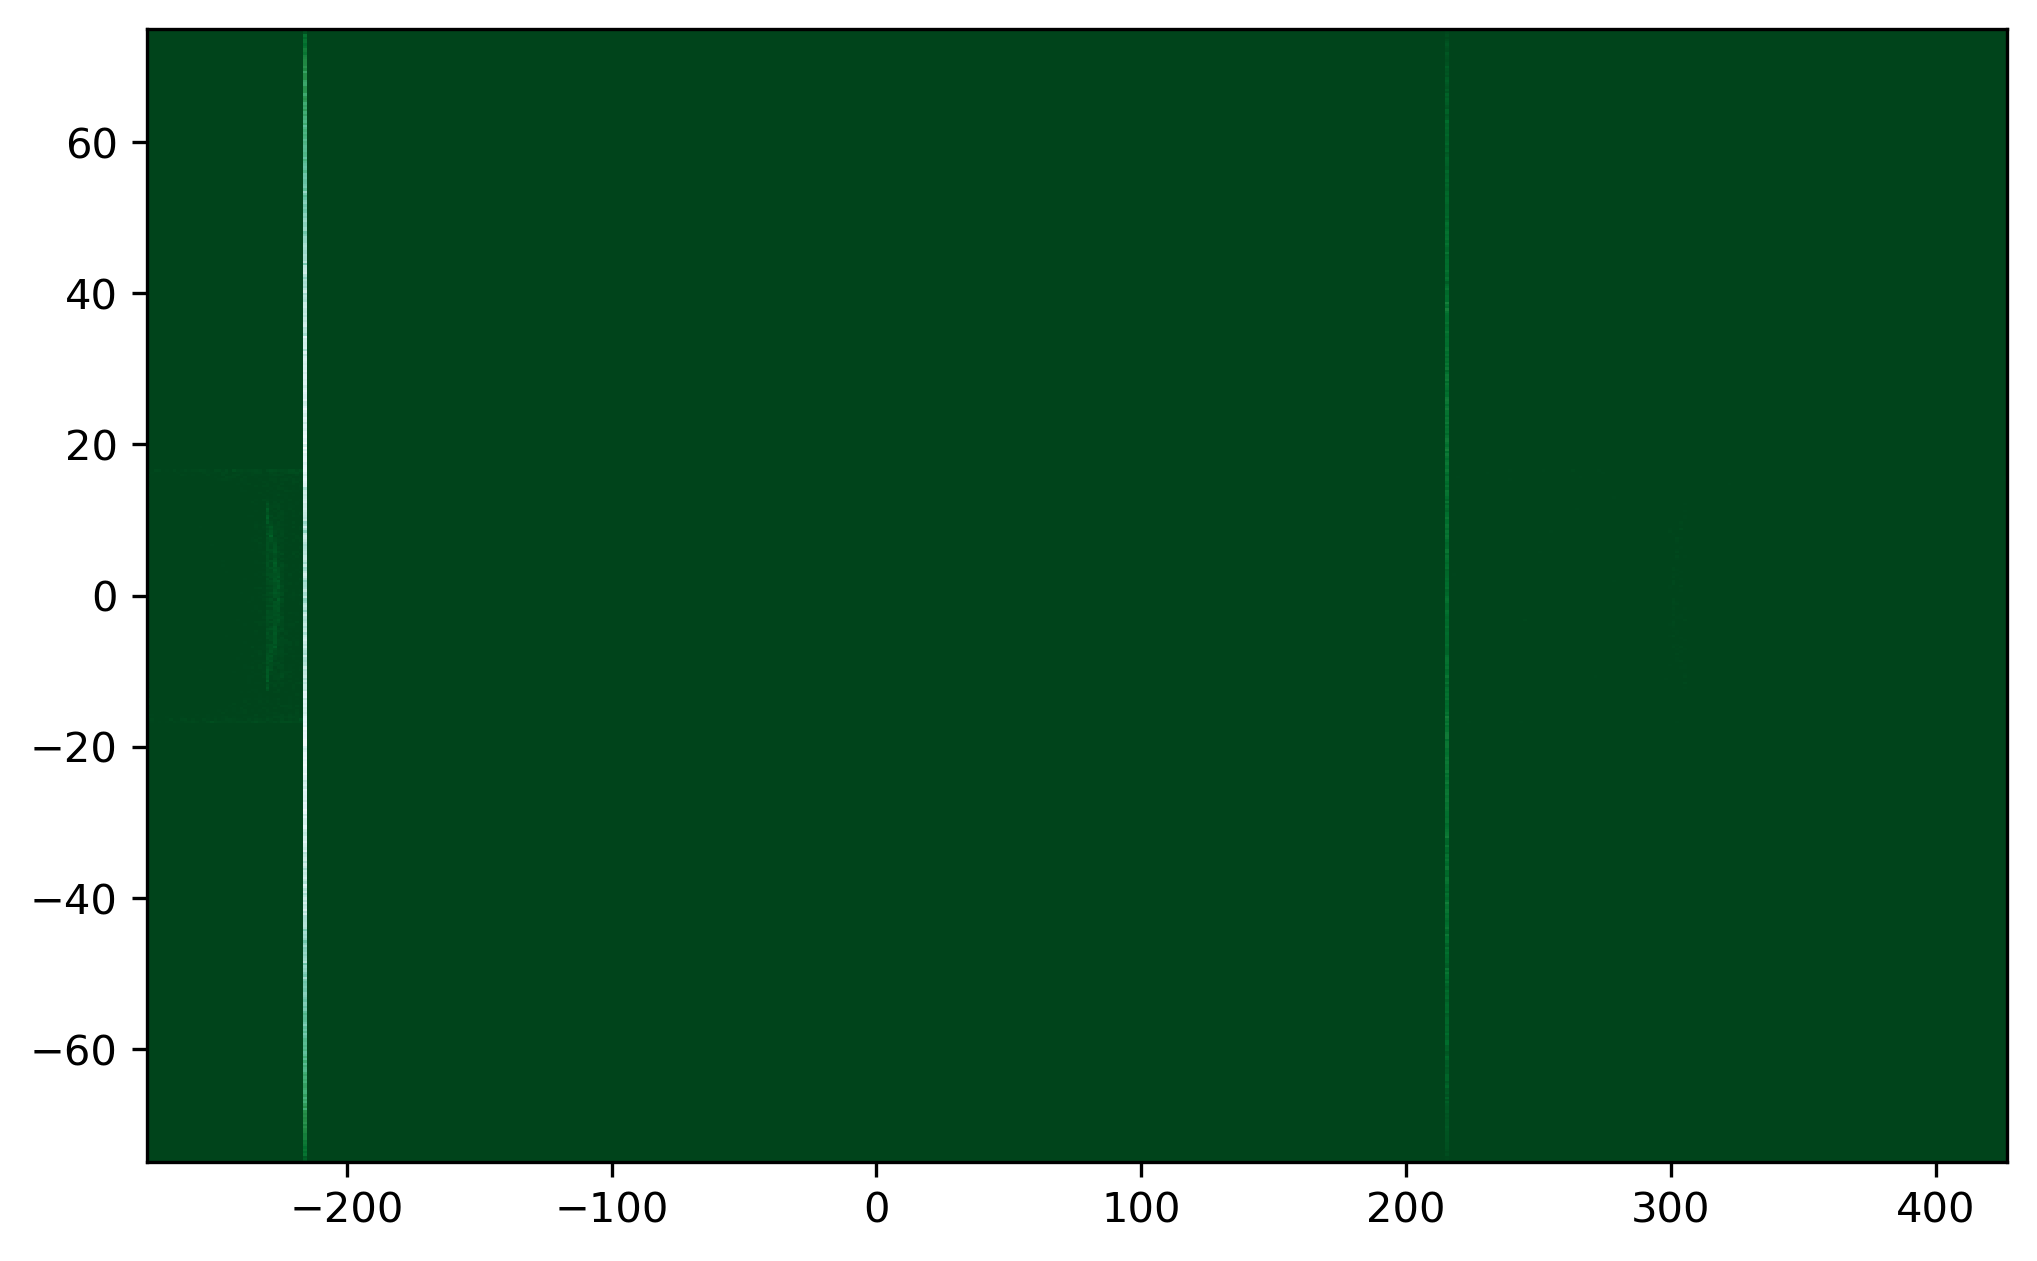

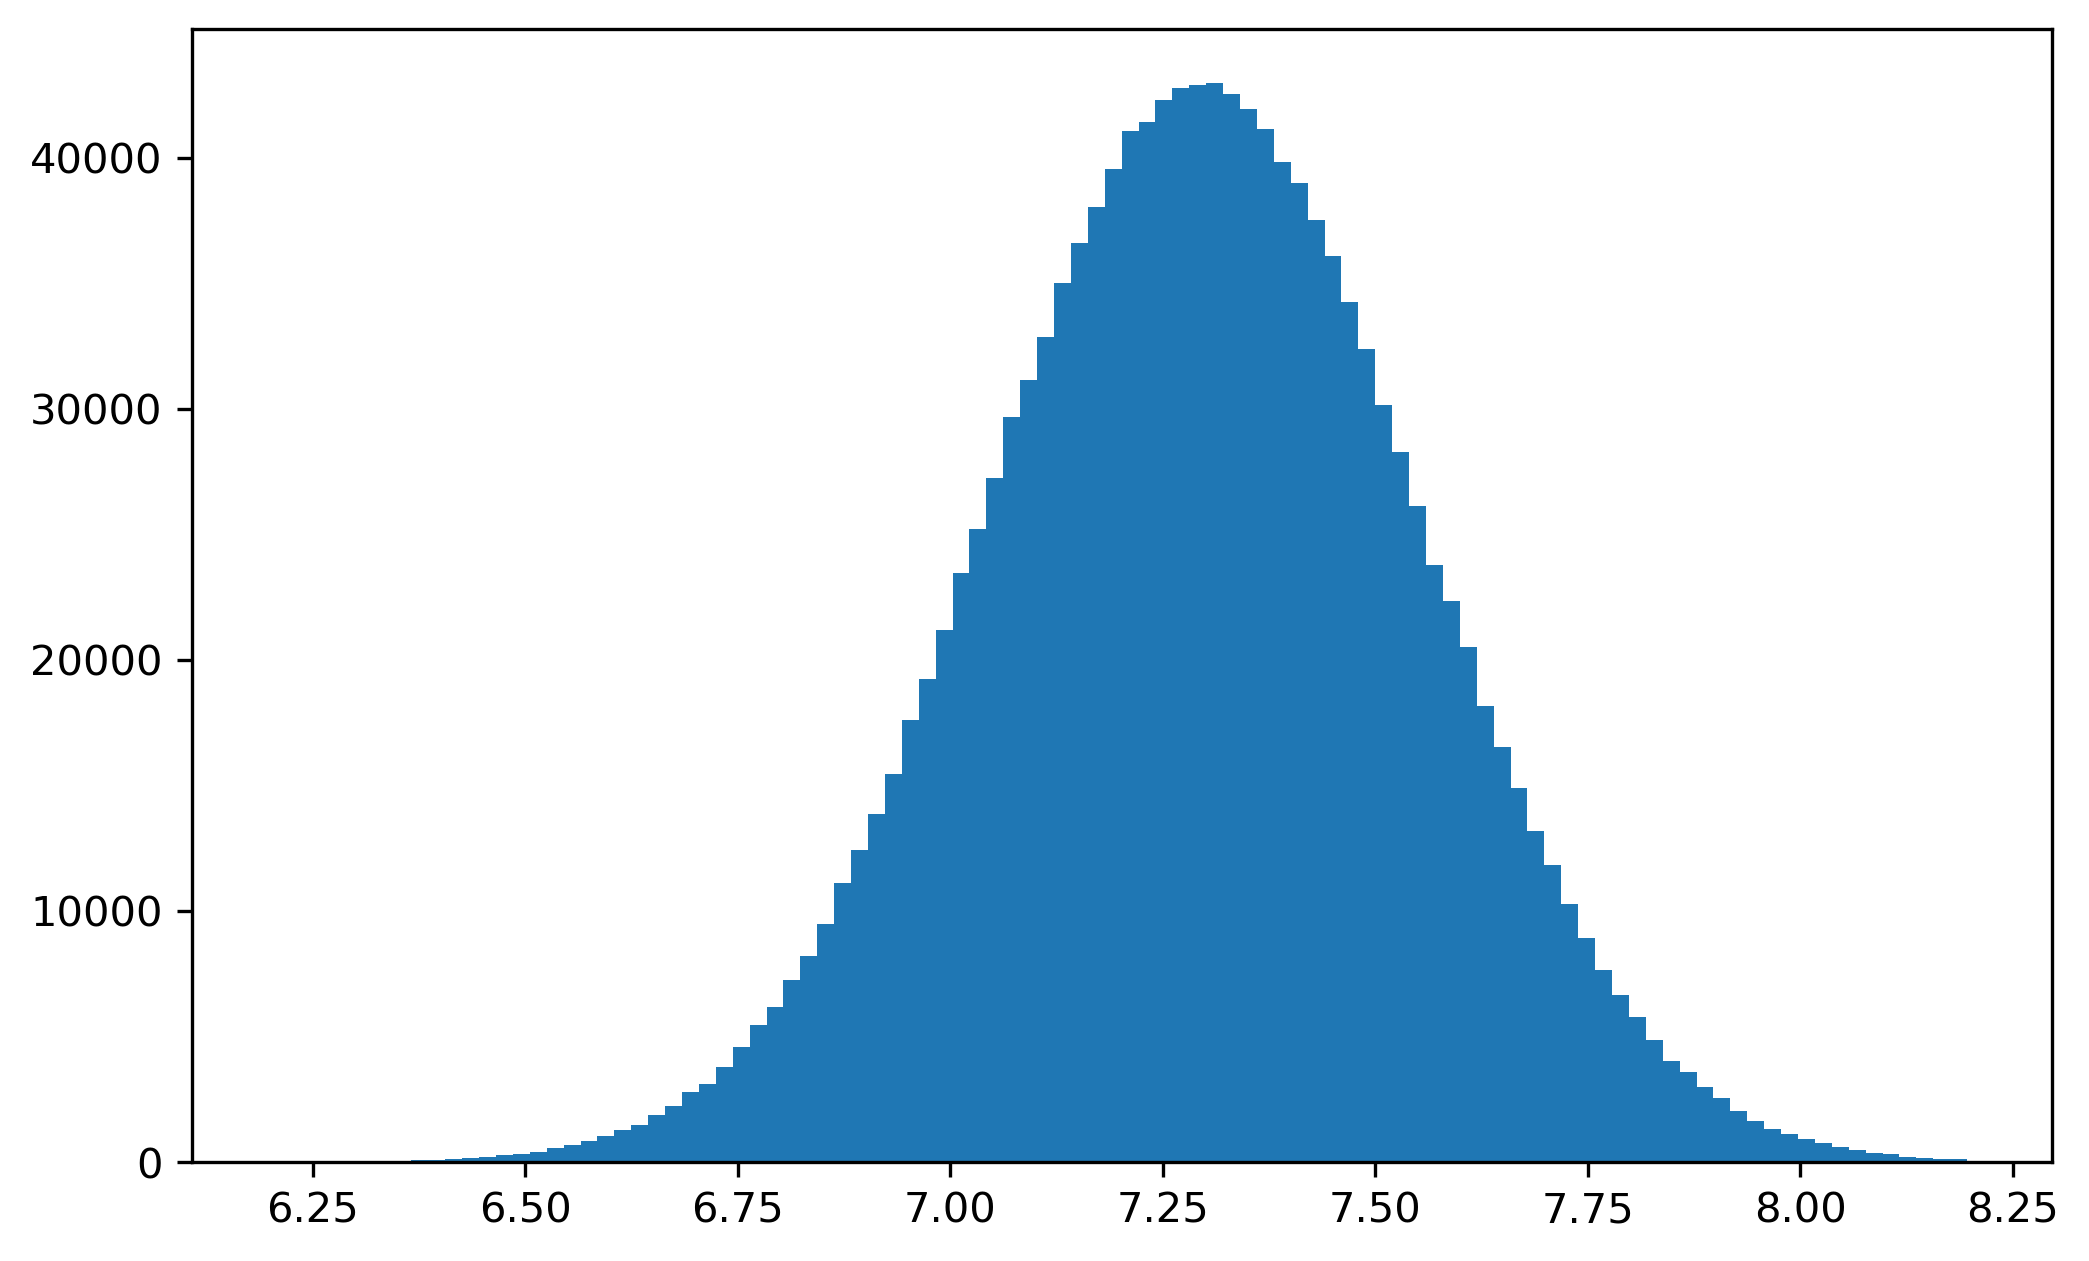

 7.29587984085083 stdev 


In [4]:
DataMaskS1=Data[0][1]==b'S1_PHOTOCATHODE'
DataMaskS2=Data[0][1]==b'S2_PHOTOCATHODE'
DataMask=Data[0][1]!=b'CHAMBER'
print(61/len(Data[0][1][DataMaskS1]))
print(542/len(Data[0][1][DataMaskS2]))

plt.figure(figsize=(8,5),dpi=300)
plt.hist2d(Data[0][0][2][DataMask],Data[0][0][1][DataMask],bins=(500,500),cmap=plt.cm.BuGn_r)
plt.show()
plt.figure(figsize=(8,5),dpi=300)
E=Data[0][2]*1e6 ### Conversion from MegaElectronVolt GEANT4 Thing
plt.hist(E,bins=100)
plt.show()
mean=st.mean(E)

#stdev=st.stdev(np.array(Data[0][2]))
print(f" {mean} stdev ")

In [6]:
Data2=getParticles("/media/ilker/Ilker/CRAB/Simulation/For_Nick/WithNicksYieldv2.h5")

[-24.25742  -13.866631  39.507385 ...  72.217     69.47924  -74.69795 ]


0.0872093023255814
0.0446927374301676


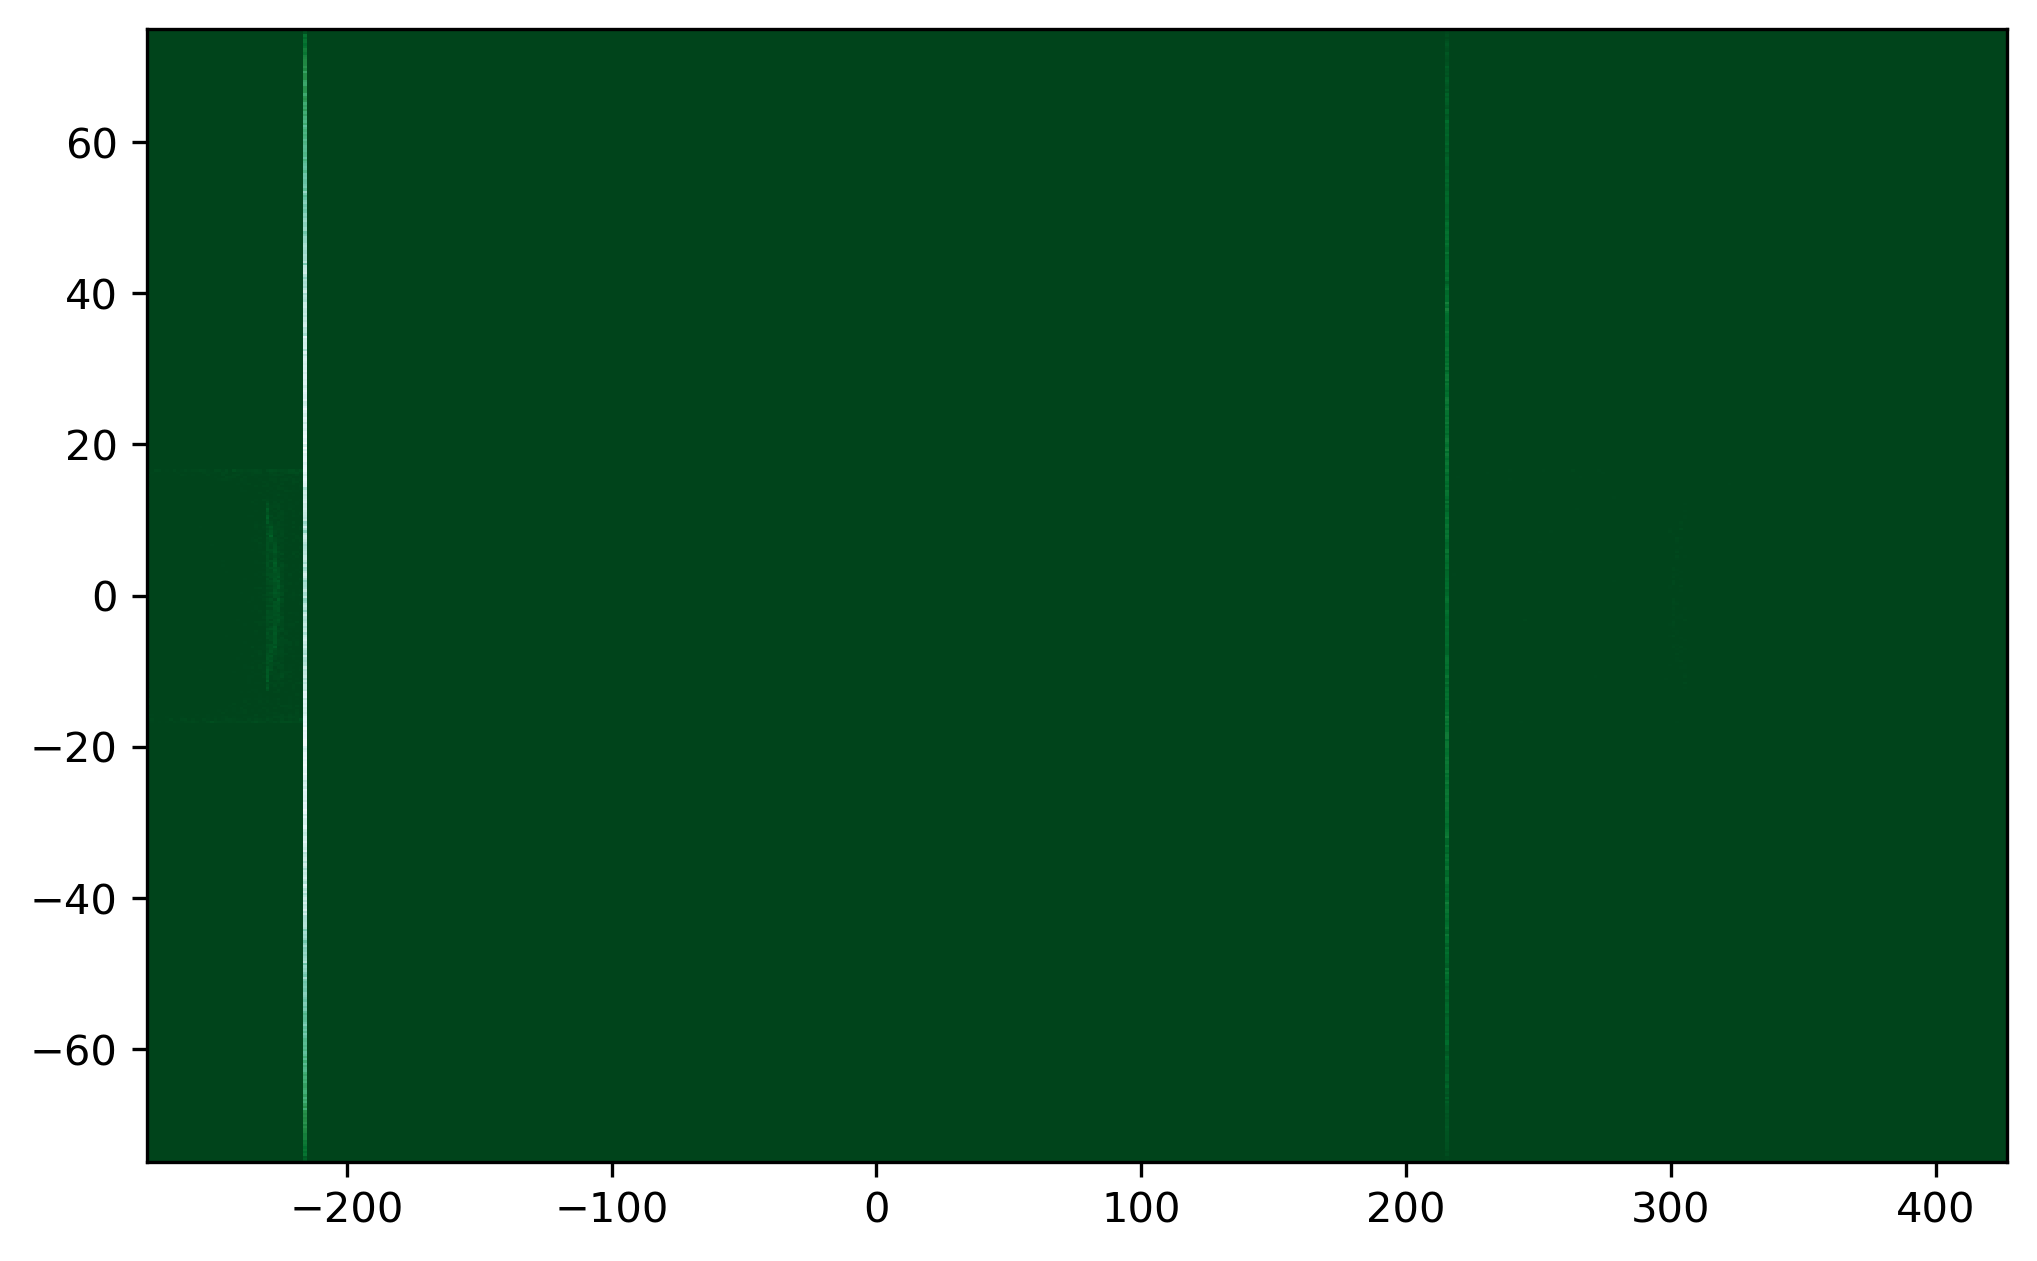

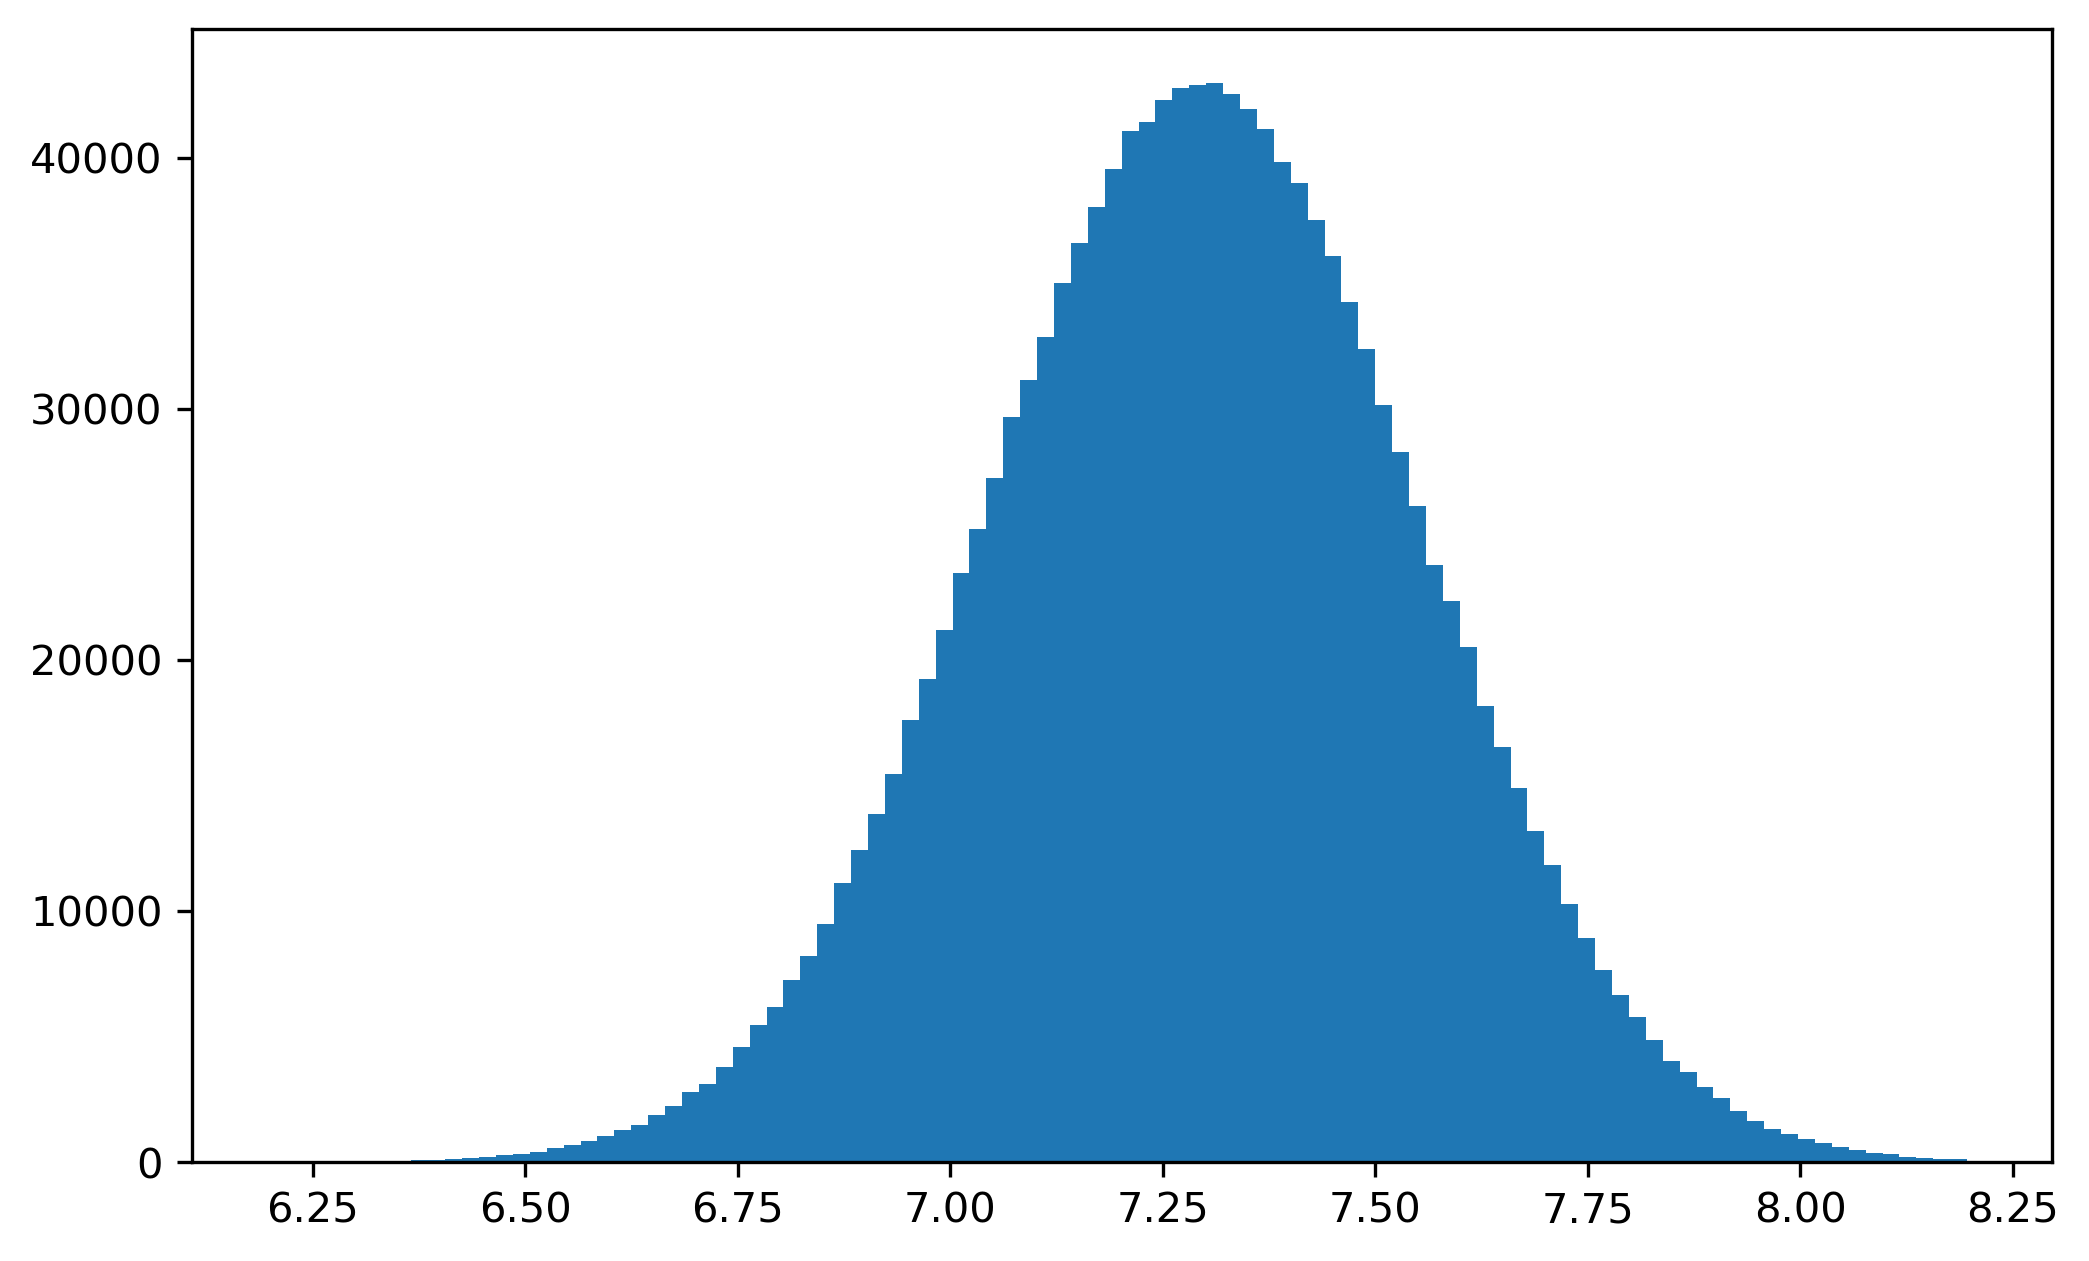

 7.29587984085083 stdev 


In [14]:
Data2MaskS1=Data2[0][1]==b'S1_PHOTOCATHODE'
Data2MaskS2=Data2[0][1]==b'S2_PHOTOCATHODE'
Data2Mask=Data2[0][1]!=b'CHAMBER'

print(15/len(Data[0][1][DataMaskS1]))
print(72/len(Data[0][1][DataMaskS2]))
plt.figure(figsize=(8,5),dpi=300)
plt.hist2d(Data2[0][0][2][Data2Mask],Data2[0][0][1][Data2Mask],bins=(500,500),cmap=plt.cm.BuGn_r)
plt.show()
plt.figure(figsize=(8,5),dpi=300)
E=Data2[0][2]*1e6 ### Conversion from MegaElectronVolt GEANT4 Thing
plt.hist(E,bins=100)
plt.show()
mean=st.mean(E)

#stdev=st.stdev(np.array(Data[0][2]))
print(f" {mean} stdev ")